<a href="https://colab.research.google.com/github/punkmic/Topic-Modeling-Reclame-Aqui/blob/master/Topic_Modeling_with_BERTopic_Reclame_aqui.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Topic Modeling with BERTopic - Reclame Aqui**

BERTopic is a topic modeling technique that leverages transformers and a custom class-based TF-IDF to create dense clusters allowing for easily interpretable topics whilst keeping important words in the topic descriptions 

Reference: (https://maartengr.github.io/BERTopic/index.html).

### **Enabling the GPU**

We will use the GPU provided by COLAB to accelarate our model training. To enable GPUs for the notebook:
1- Navigate to Edit -> Notebook Settings
2- Select GPU from the Hardware Accelerator drop-down

In [12]:
# verify if GPU is enable
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


### **Setup**

In [13]:
%%capture
!pip install pyspellchecker
!pip install bertopic
!pip install kaleido # for save BERTopic plots as image
!pip install optuna
!pip install hdbscan
!pip install umap-learn
!pip install gensim
!pip install pyldavis

In [15]:
import pandas as pd # for data manipulation
import os # for interacting with the operating system
import nltk # for natural language processing
import string # for string manipulation
import re # for for regular expressions
import matplotlib.pyplot as plt # for visualization
import spacy # for lemmatize portuguese text
from bertopic import BERTopic # for topic modeling
from spellchecker import SpellChecker # for spell check
import json
import optuna # for hyperparameter optimization
from hdbscan import HDBSCAN # for clustering
from sklearn.cluster import KMeans # for clustering
from umap import UMAP # for dimension reduction
from sklearn.decomposition import PCA # for dimension reduction
from sklearn.feature_extraction.text import CountVectorizer # for convert text documents to matrix of tokens count
from bertopic.vectorizers import ClassTfidfTransformer 
import ast # for convert str to tuple
import csv
from gensim import models
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
import numpy as np
import pickle 
import pyLDAvis
from gensim.utils import simple_tokenize
from gensim.models import LdaMulticore
from gensim.utils import simple_preprocess

/usr/local/lib/python3.8/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable


In [16]:
%%capture
# Install spacy pt_core_news_sm for portuguese text
!python -m spacy download pt_core_news_sm

In [17]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [18]:
# Download dataset with stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [19]:
# Donwload datasets for lemmatization
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [20]:
# Donwload dependency need to stem portuguese text
nltk.download('rslp')

[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


True

### **Load data from [Github](https://github.com/punkmic/Topic-Modeling-Reclame-Aqui.git)**

In [ ]:
#!git clone https://github.com/punkmic/Topic-Modeling-Reclame-Aqui.git

In [ ]:
# Change directory
%cd /content/Topic-Modeling-Reclame-Aqui 

# Update files from remote repository
!git pull 

# Return to work directory
%cd ..

# Check current directory
!pwd

In [21]:
WORK_DIR = '/content/Topic-Modeling-Reclame-Aqui/'

In [22]:
def read_data(path_csv, drop_duplicates = True, lower=True):
 
  # use the read_csv method to read csv file
  df = pd.read_csv(path_csv)
  
  if drop_duplicates:
    # read and return the CSV file using the read_csv method
    print(f"Shape before remove duplicates: {df.shape}")

    # use the drop_duplicated method to drop duplicates rows
    df = df.drop_duplicates(subset="text")

    print(f"Shape after remove duplicates: {df.shape}")

    if lower:
      # apply the str.lower() method to each element in the dataframe
      df = df.applymap(str.lower)
    
     # rename columns
    df.columns = ["title", "documents"] 

    # use the replace() method to replace the string with an empty string
    df = df.replace(re.compile('\[editado pelo reclame aqui\]|editado pelo reclame aqui|Editado pelo Reclame Aqui'), '')
    df = df.replace(re.compile('\[casas bahia\]|Casa Bahia|Casas Bahia|casa bahia'), '')
    df = df.replace(re.compile('\[magazine luiza\]|Magazine luiza|Magazine Luiza| Magazine luizar|Magazine Luizar'), '')
    df = df.replace(re.compile('\[mercado livre\]|Mercado Livre|Mercado livre'), '')
    df = df.replace(re.compile('\[americana\]|Ameriacanas|ameriacanas'), '')

  return df

<>:23: DeprecationWarning: invalid escape sequence \[
<>:24: DeprecationWarning: invalid escape sequence \[
<>:25: DeprecationWarning: invalid escape sequence \[
<>:26: DeprecationWarning: invalid escape sequence \[
<>:27: DeprecationWarning: invalid escape sequence \[
<>:23: DeprecationWarning: invalid escape sequence \[
<>:24: DeprecationWarning: invalid escape sequence \[
<>:25: DeprecationWarning: invalid escape sequence \[
<>:26: DeprecationWarning: invalid escape sequence \[
<>:27: DeprecationWarning: invalid escape sequence \[
<ipython-input-22-c602cfad55fa>:23: DeprecationWarning: invalid escape sequence \[
  df = df.replace(re.compile('\[editado pelo reclame aqui\]|editado pelo reclame aqui|Editado pelo Reclame Aqui'), '')
<ipython-input-22-c602cfad55fa>:24: DeprecationWarning: invalid escape sequence \[
  df = df.replace(re.compile('\[casas bahia\]|Casa Bahia|Casas Bahia|casa bahia'), '')
<ipython-input-22-c602cfad55fa>:25: DeprecationWarning: invalid escape sequence \[
  df 

### **Preprocessing**

#### **Tokenization**

Tokenization aims to breaking text down into its component parts

In [23]:
WORD_TOKENIZER = nltk.tokenize.word_tokenize
def tokenize(text):
  tokens = [token.strip().lower() for token in WORD_TOKENIZER(text, language="portuguese")]
 
  # set a pattern to detect patterns such as x x, xxx x, xxx xxx
  pattern = r"\b\w+\s+\w+\b"
 
  # filter tokens by pattern
  filtered_words = [word for word in tokens if re.search(pattern, word)]

  # return token if not in filter list
  return [token for token in tokens if token not in filtered_words]

#### **Stem** 

Stem the tokens. This step aims to remove morphological affixes and normalize to standardized stem forms

In [24]:
STEMMER = nltk.stem.RSLPStemmer()
def stem(tokens):
  return [STEMMER.stem(token) for token in tokens]

#### **Lemmatize**

Lemmatize the tokens. Retains more natural forms than stemming, but assumes all tokens nons unless tokens are passed as (word, pos) tuples. Note: nltk lemmatize does not suport portugues language

In [25]:
LEMMATIZER = nltk.WordNetLemmatizer()

def lemmatize(tokens):
  lemmas = []
  for token in tokens:
      if isinstance(token, str):
          # treats token like a noun
          lemmas.append(LEMMATIZER.lemmatize(token)) 
      else: 
          # assume a tuple of (word, pos)
          lemmas.append(LEMMATIZER.lemmatize(*token))
  return lemmas

**Lemmatize option for portuguese text**

In [26]:
# load portuguese model
nlp = spacy.load('pt_core_news_sm')

def lemmatize_pt(tokens):

  # Create a spaCy Doc object and apply the lemmatization
  doc = nlp(' '.join(tokens))

  # Return lemmatize
  return [token.lemma_ for token in doc]

#### **Remove stopwords**

Stop words are things like articles and conjunctions that usually do not offer a lot of value in an analysis.

In [27]:
custom_stop_words = ['amazon', 'americanas', 'casas bahia', 'magazine luiza', 'shein', 'kabum',
                       'samsung', 'mercado livre', 'banco brasil', 'apple', 'magazine', 'luiza', 'luizar',
                      'casas', 'bahia', 'casa', 'mercado', 'livre','magalu']

In [28]:
def remove_stopwords(tokens, stopwords=None, custom_stop_words = None):

  if custom_stop_words is None:
    custom_stop_words = ['amazon', 'americanas', 'casas bahia', 'magazine luiza', 'shein', 'kabum',
                       'samsung', 'mercado livre', 'banco brasil', 'apple', 'magazine', 'luiza', 'luizar',
                      'casas', 'bahia', 'casa', 'mercado', 'livre']

  # Use the default stop words if none is passed
  if stopwords is None:
    stopwords = nltk.corpus.stopwords.words('portuguese') + custom_stop_words
  
  # Filter the list of tokens to exclude the stop word tokens
  return [token for token in tokens if token not in stopwords]

In [29]:
assert remove_stopwords(['compra', 'echar', 'em esse', 'amazon', 'pude'], custom_stop_words=custom_stop_words) == ['compra', 'echar', 'em esse', 'pude']

#### **Remove hyperlinks**

Removes http/s links from the tokens.

In [30]:
def remove_links(tokens):
  # Filter tokens that starts with "http://" or "https://"
  return [token for token in tokens 
          if not token.startswith("http://")
          and not token.startswith("https://")]

In [31]:
assert remove_links(['bom', 'http://online', 'https://offline']) == ['bom']

#### **Remove numbers**

In [32]:
def remove_numbers(tokens):
  # Use a regular expression to match words that contain numbers
  pattern = r"\b\w*\d\w*\b"
  tokens = [token for token in tokens if not re.sub(pattern, "", token) == ""]
  
  # Filter out number tokens using a list comprehension and the isnumeric method
  return [token for token in tokens if not token.isnumeric()]

In [33]:
assert remove_numbers(['ola', 'bicicleta', '1', '2002']) == ['ola', 'bicicleta']

#### **Remove date**

In [34]:
def remove_date(tokens):
  # Compile a regular expression to match dates in the format dd/mm or dd/mm/yyyy
  date_regex = re.compile(r'\d{2}/\d{2}(/\d{4})?')

  # Use the regex to find all the tokens that match the date pattern
  dates = [token for token in tokens if date_regex.fullmatch(token)]

  # Filter the list of tokens to exclude the date tokens
  filtered_tokens = [token for token in tokens if token not in dates]

  # Return the filtered tokens
  return filtered_tokens

In [35]:
assert remove_date(['texto', 'data', '20/10', 'seguro', '02/09/2014']) == ['texto', 'data', 'seguro']

#### **Remove punctuation**

In [36]:
def remove_punctuation(tokens,
                       strip_mentions=True,
                       strip_hashtags=True):

    tokens = [re.sub(r'[^\w\s]', '', token) for token in tokens]

    # Filter punctuation tokens
    tokens = [token.strip() for token in tokens if token not in string.punctuation]

    # Remove @ symbol from left side of tokens
    if strip_mentions:
        tokens = [t.lstrip(r"([!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~])\1+") for t in tokens]

    # Remove # symbol from left side of tokens
    if strip_hashtags:
        tokens = [t.lstrip(r"([!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~])\1+") for t in tokens]

    return tokens

In [37]:
assert remove_punctuation(['limpo', 'acento/  ///', 'simples???', 'onde', ',']) == ['limpo', 'acento', 'simples', 'onde']

#### **Remove short tokens**

In [38]:
def remove_short_tokens(tokens):
  # Filter the list of tokens to exclude tokens that are shorter than four letters
  filtered_tokens = [token for token in tokens if len(token) >= 4]

  # Return the filtered tokens
  return filtered_tokens

In [39]:
assert remove_short_tokens(['sair', 'um', 'correto', 'igual', 'oi', 'de', 'em']) == ['sair', 'correto', 'igual']

#### **Correction of spelling errors**

In [40]:
# Create a SpellChecker object
spell = SpellChecker(language='pt')

def check_spell_errors(text):
  result = []
  for token in text:
    # Correct the spelling errors in the text
    corrected_text = spell.correction(token)

    # If no correction is present user the original text
    if corrected_text == None:
      corrected_text =  token
  
    result.append(corrected_text)
  # Return the corrected text
  return result

#### **Remove extra white spaces**

In [41]:
def remove_whitespace(document):
    return  " ".join(document.split())

In [42]:
def preprocess(df, colname, custom_process = None, check_spell = False):
  df[colname]= df[colname].str.lower()
  df[colname]= df[colname].apply(remove_whitespace)

  if custom_process is None:
    df[colname] = df[colname].apply(tokenize)
    if check_spell:
      df[colname] = df[colname].apply(check_spell_errors)
    df[colname] = df[colname].apply(remove_links)
    df[colname] = df[colname].apply(remove_punctuation)
    df[colname] = df[colname].apply(remove_numbers)
    df[colname] = df[colname].apply(remove_date)
    df[colname] = df[colname].apply(remove_short_tokens)
    df[colname] = df[colname].apply(remove_stopwords)
    df[colname] = df[colname].apply(lemmatize_pt) 
    df[colname] = df[colname].apply(lambda x: ' '.join(x))
  else:
    if 'tokenize' in custom_process:
      df[colname] = df[colname].apply(tokenize)
    if 'check_spell' in custom_process:
      df[colname] = df[colname].apply(check_spell_errors) 
    if 'remove_links' in custom_process:
      df[colname] = df[colname].apply(remove_links)
    if 'remove_punctuation' in custom_process:
      df[colname] = df[colname].apply(remove_punctuation)
    if 'remove_numbers' in custom_process:
      df[colname] = df[colname].apply(remove_numbers)
    if 'remove_date' in custom_process:
      df[colname] = df[colname].apply(remove_date)
    if 'remove_short_tokens' in custom_process:
      df[colname] = df[colname].apply(remove_short_tokens)
    if 'remove_stopwords' in custom_process:
      df[colname] = df[colname].apply(remove_stopwords)
    if 'lemmatize' in custom_process:
      df[colname] = df[colname].apply(lemmatize_pt)
    if 'steam' in custom_process and 'lemmatize' not in custom_process:
      df[colname] = df[colname].apply(stem)
  return df

In [43]:
def get_data(features):
  dfs = {}
  # create models for documents and title features
  df = None
  for feature in features:
    if not os.path.exists(WORK_DIR + f'results/dataset/preprocessed/table_{feature}.csv'):

      path_csv = WORK_DIR + "docs.csv"
  
      if df is None:
        # read data 
        df = read_data(path_csv)
        dfs['raw'] = df
  
      # preprocess data
      df = preprocess(df, feature)

      # Set the path to save 
      path = WORK_DIR + 'results/dataset/preprocessed/'

      # Use makedirs() to create a new directory if it does not exists
      if not os.path.exists(path):
        os.makedirs(path)

      # Save the DataFrame to a CSV file
      df.to_csv(path + f'table_{feature}.csv', index=False)
      print(f'Dataset saved into {path}')
  for feature in features:
    df_processed = pd.read_csv(WORK_DIR + f'results/dataset/preprocessed/table_{feature}.csv')
    dfs[feature] = df_processed
  return dfs

In [44]:
features=['title', 'documents']
dfs = get_data(features)
print(dfs.keys())

Shape before remove duplicates: (12760, 2)
Shape after remove duplicates: (10510, 2)
Dataset saved into /content/Topic-Modeling-Reclame-Aqui/results/dataset/preprocessed/
Dataset saved into /content/Topic-Modeling-Reclame-Aqui/results/dataset/preprocessed/
dict_keys(['raw', 'title', 'documents'])


In [45]:
DATA_FRAME_FEATURE_NAME = 'documents'

docs = list(dfs[DATA_FRAME_FEATURE_NAME]['documents'])
print(docs[0:10])

['pesquisando bastante novo comprar resolver aguardar semana cliente porque ocorrer vários desconto promoção em esse semana ser assim recebi desconto cashback cupom varia plataforma assim decidir efetuar compra entender melhor custo beneficio ser assim setembro recebi oferta produto entendi preço além cachback efetuei comprar aguardei semana consumidor efetuar todo expectativa estavar ancioso estar dentro prazo entregar hoje resolver enviar mensagem perguntar pedir enviar após confirmação comprar pagamento passado dia nenhum retorno complei inclusive site confio tambem assinante surpresa após pedir informação pedir retorno email estar ser cancelar ser nenhum justificativa após dia realização aguardei chegar periodo compro ansiosamente aproveitar desconto produto familia aguardar além cancelar compra produto justificativa empresa tirar todo oportunidade desconto efetuar compra semano consumidor levar dia cancelar sinto extremamente empresa sempre acreditar aguardo satisfação reparação t

## **Training a BERTopic Model**

The BERTopic algorithm has several advantages over other topic modeling algorithms. It is able to handle sparse data, it is scalable to large datasets, and it is able to learn topics that are not well-defined or are overlapping.

As our data language is portuguese we will going to set language to multilingual.

Create a new BERTopic model and train it. By default BERTopic use the paraphrase-multilingual-MiniLM-L12-v2 model for multi language documents. For others model check here [BERTopic sentence transformers](https://maartengr.github.io/BERTopic/getting_started/embeddings/embeddings.html#sentence-transformers)

In [46]:
# Create a new BERTopic model using multilingual option
topic_model = BERTopic(language="multilingual", calculate_probabilities=True, verbose=True)

# Train model 
topics, probs = topic_model.fit_transform(docs)

Downloading:   0%|          | 0.00/968 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.79k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/645 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/471M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/480 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/14.8M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Batches:   0%|          | 0/329 [00:00<?, ?it/s]

2023-01-11 03:51:06,774 - BERTopic - Transformed documents to Embeddings
2023-01-11 03:51:45,511 - BERTopic - Reduced dimensionality
2023-01-11 03:51:50,429 - BERTopic - Clustered reduced embeddings


BERTopic works in three main steps: 


1.   Documents are first converted to numeric data. It extracts different embeddings based on the context of the word. For this, a sentence transformation model is used.
2.  Documents with similar topics are then grouped together forming clusters with similar topics. For this purpose, BERTopic uses the clustering algorithm UMAP to lower the dimensionality of the embeddings. Then the documents are clustered with the density-based algorithm HDBSCAN.
3. BERTopic extracts topics from clusters using a class-based TF-IDF score. This score gives the importance of each word in a cluster. Topics are then created based on the most important words measured by their C-TF-IDF score.

For more information check this link [BERTopic](https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6)



#### **BERTopic coherence score**

In [100]:
def get_coherence(model, topics, docs):
  # Preprocess Documents
  documents = pd.DataFrame({"Document": docs,
                          "ID": range(len(docs)),
                          "Topic": topics})
  documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
  #cleaned_docs = model._preprocess_text(documents_per_topic.Document.values)

  # Extract vectorizer and analyzer from BERTopic
  vectorizer = model.vectorizer_model
  analyzer = vectorizer.build_analyzer()

  # Extract features for Topic Coherence evaluation
  tokens = [analyzer(doc) for doc in documents_per_topic.Document.values]
  dictionary = Dictionary(tokens)
  corpus = [dictionary.doc2bow(token) for token in tokens]
  topic_words = [[words for words, _ in model.get_topic(topic)] 
               for topic in range(len(set(topics))-1)]

  # Evaluate
  coherence_model = CoherenceModel(topics=topic_words, 
                                 texts=tokens, 
                                 corpus=corpus,
                                 dictionary=dictionary, 
                                 coherence='c_v')
  coherence = coherence_model.get_coherence()
  return coherence

In [99]:
print(f"Coeherence score: {get_coherence(topic_model, topics, docs)}")

Coeherence score: 0.4877774840016643


### **Extracting Topics**

In [ ]:
# Print the most frequent topics
freq = topic_model.get_topic_info()

# Show the top 5 most frequent topics
freq.head(5)

The table above shows the five most freqeuente topics and the words present on it extract by BERTopic. -1 refers to all outliers and should be ignored.

In [ ]:
# show the most frequent topic
topic_model.get_topic(0)

**Note:** BERTopic is stocastich which means that the topics might differ across runs this is mostly due to the stocastisch nature of UMAP

#### **Save topic info table as CSV**

In [ ]:
# Set the path to save 
path = WORK_DIR + f'results/{DATA_FRAME_FEATURE_NAME}/topic_info_tables/'

# Use makedirs() to create a new directory if it does not exists
if not os.path.exists(path):
  os.makedirs(path)

# Save table as csv
freq.head(10).to_csv(path + 'topic_info_preprocessed_lemma.csv', index=False)

## **Visualization**

### **Intertopic Distance Map**

This graph shows the distance intertopic and help us understand the promixity of topics

In [ ]:
fig = topic_model.visualize_topics(width=800, height=800)
fig

#### **Save intertopic distance map**

In [ ]:
# Set the path to save 
path = WORK_DIR + f'results/{DATA_FRAME_FEATURE_NAME}/intertopic_distance_map/'

# Use makedirs() to create a new directory if it does not exists
if not os.path.exists(path):
  os.makedirs(path)


fig.write_image(path + "idm_preprocessed_lemma.png", format="png")
fig.write_html(path + "idm_preprocessed_lemma.html")

[Github link](https://github.com/punkmic/Topic-Modeling-Reclame-Aqui/blob/master/results/intertopic_distance_map/idm_preprocessed_lemma.png?raw=true)

### **Visualize Topic Hierarchy**

The topics that were created can be hierarchically reduced. This visualization shows how the topics relate to one another.

In [ ]:
fig = topic_model.visualize_hierarchy(top_n_topics=30, width=800, height=800)
fig

#### **Save Hierarchical Clustering**

In [ ]:
# Set the path to save 
path = WORK_DIR + f'results/{DATA_FRAME_FEATURE_NAME}/hierarchical_clustering/'

# Use makedirs() to create a new directory if it does not exists
if not os.path.exists(path):
  os.makedirs(path)


fig.write_image(path + "hc_preprocessed_lemma.png", format="png")

[Github link](https://github.com/punkmic/Topic-Modeling-Reclame-Aqui/blob/master/results/hierarchical_clustering/hc_preprocessed_lemma.png?raw=true)

### **Visualize Terms**

We can visualize the selected terms for a few topics by creating bar charts out of the c-TF-IDF scores for each topic representation.

In [ ]:
fig = topic_model.visualize_barchart(top_n_topics=12, width=300, height=300)
fig

#### **Save Top Word Scores Bar Chart**

In [ ]:
# Set the path to save 
path = WORK_DIR + f'results/{DATA_FRAME_FEATURE_NAME}/top_words_scores/'

# Use makedirs() to create a new directory if it does not exists
if not os.path.exists(path):
  os.makedirs(path)


fig.write_image(path + "tws_preprocessed_lemma.png", format="png")

[Github link](https://github.com/punkmic/Topic-Modeling-Reclame-Aqui/blob/master/results/top_words_scores/tws_preprocessed_lemma.png?raw=true)

### **Visualize Topic Similarity**

This plot shows a similarity matrix by simply applying cosine similarities through those topic embeddings generate by BERTopic through both c-TF-IDF and embeddings. This matrix indicate how similar certain topics are to each other.

In [ ]:
fig = topic_model.visualize_heatmap(n_clusters=20, width=800, height=800)
fig

#### **Save Similarity Matrix**

In [ ]:
# Set the path to save 
path = WORK_DIR + f'results/{DATA_FRAME_FEATURE_NAME}/similarity_matrix/'

# Use makedirs() to create a new directory if it does not exists
if not os.path.exists(path):
  os.makedirs(path)


fig.write_image(path + "sm_preprocessed_lemma.png", format="png")

[Github link](https://github.com/punkmic/Topic-Modeling-Reclame-Aqui/blob/master/results/similarity_matrix/sm_preprocessed_lemma.png?raw=true)

### **Visualize Term Score Decline**

Topics are represented by a number of words starting with the best representative word. Each word is represented by a c-TF-IDF score. The higher the score, the more representative a word to the topic is. Since the topic words are sorted by their c-TF-IDF score, the scores slowly decline with each word that is added.

In [ ]:
fig = topic_model.visualize_term_rank()
fig

#### **Save Term score decline per Topic**

In [ ]:
# Set the path to save 
path = WORK_DIR + f'results/{DATA_FRAME_FEATURE_NAME}/term_score_decline_topic/'

# Use makedirs() to create a new directory if it does not exists
if not os.path.exists(path):
  os.makedirs(path)


fig.write_image(path + "tsdp_preprocessed_lemma.png", format="png")

[Github link](https://github.com/punkmic/Topic-Modeling-Reclame-Aqui/blob/master/results/term_socore_decline_topic/tsdp_preprocessed_lemma.png?raw=true)

### **Term search**

In [ ]:
# Find topics that contains blackfriday term
similar_topics, similarity = topic_model.find_topics("blackfriday", top_n=5)

# Show similar topics
similar_topics

In [ ]:
# Show a specific topic
topic_model.get_topic(64)

### **"Hiperparameter optimization"**

In [ ]:
def save_documents(model, docs, label):
  fig = topic_model.visualize_documents(docs, hide_document_hover=True, hide_annotations=True, width=800, height=800)

  # Set the path to save 
  path = WORK_DIR + f'results/{DATA_FRAME_FEATURE_NAME}/documents_n_topics/'

  # Use makedirs() to create a new directory if it does not exists
  if not os.path.exists(path):
    os.makedirs(path)

  fig.write_image(path + f"document_n_topics_trial_{label}.png", format="png")
  fig.write_html(path + f"document_n_topics_trial_{label}.html")

In [ ]:
def save_topics(model, label):
  fig = model.visualize_topics(width=800, height=800)

  # Set the path to save 
  path = WORK_DIR + f'results/{DATA_FRAME_FEATURE_NAME}/intertopic_distance_map/'

  # Use makedirs() to create a new directory if it does not exists
  if not os.path.exists(path):
    os.makedirs(path)

  fig.write_image(path + f"intertopic_distance_map_trial_{label}.png", format="png")
  fig.write_html(path + f"intertopic_distance_map_trial_{label}.html")

In [ ]:
def save_hierarchy(model, label):
  fig = model.visualize_hierarchy(width=800, height=800)

  # Set the path to save 
  path = WORK_DIR + f'results/{DATA_FRAME_FEATURE_NAME}/hierarchical_clustering/'

  # Use makedirs() to create a new directory if it does not exists
  if not os.path.exists(path):
    os.makedirs(path)

  fig.write_image(path + f"hierarchical_clustering_trial_{label}.png", format="png")
  fig.write_html(path + f"hierarchical_clustering_trial_{label}.html")

In [ ]:
def save_top_words_scores(model, label):
  fig = model.visualize_barchart(top_n_topics=12, width=300, height=300)

  # Set the path to save 
  path = WORK_DIR + f'results/{DATA_FRAME_FEATURE_NAME}/top_words_scores/'

  # Use makedirs() to create a new directory if it does not exists
  if not os.path.exists(path):
    os.makedirs(path)

  fig.write_image(path + f"top_words_scores_trial_{label}.png", format="png")
  fig.write_html(path + f"top_words_scores_trial_{label}.html")

In [ ]:
def save_similarity_matrix(model, label):
  fig = model.visualize_heatmap()

  # Set the path to save 
  path = WORK_DIR + f'results/{DATA_FRAME_FEATURE_NAME}/similarity_matrix/'

  # Use makedirs() to create a new directory if it does not exists
  if not os.path.exists(path):
    os.makedirs(path)

  fig.write_image(path + f"similarity_matrix_trial_{label}.png", format="png")
  fig.write_html(path + f"similarity_matrix_trial_{label}.html")

In [ ]:
def save_term_rank(model, label):
  fig = model.visualize_term_rank(width=800, height=800)

  # Set the path to save 
  path = WORK_DIR + f'results/{DATA_FRAME_FEATURE_NAME}/term_score_decline_topic/'

  # Use makedirs() to create a new directory if it does not exists
  if not os.path.exists(path):
    os.makedirs(path)

  fig.write_image(path + f"term_score_trial_{label}.png", format="png")
  fig.write_html(path + f"term_score_trial_{label}.html")

In [ ]:
def save_hyperparameters(trial_params, label):
  # Set the path to save 
  path = WORK_DIR + f'results/{DATA_FRAME_FEATURE_NAME}/hyperparameters/'

  # Use makedirs() to create a new directory if it does not exists
  if not os.path.exists(path):
    os.makedirs(path)

  with open(path + f"hyperparameters_trial_{label}.json", "w") as f:
    f.write(json.dumps(trial_params))

In [ ]:
def save_freq_topics(model, label):
  # Print the most frequent topics
  freq = topic_model.get_topic_info()

  # Show the top 5 most frequent topics
  freq = freq.head(5)

  # Set the path to save 
  path = WORK_DIR + f'results/{DATA_FRAME_FEATURE_NAME}/frequent_topics/' 

  # Use makedirs() to create a new directory if it does not exists
  if not os.path.exists(path):
    os.makedirs(path)

  freq.to_html(path + f"freq_topics_trial_{label}.json")
  freq.to_csv(path + f"freq_topics_trial_{label}.csv", index=False)

In [ ]:
def save_model(model, label):
  # save model
  path = WORK_DIR + f'results/{DATA_FRAME_FEATURE_NAME}/models/'

  # Use makedirs() to create a new directory if it does not exists
  if not os.path.exists(path):
    os.makedirs(path)

  model.save(path + label)

In [ ]:
lda_scores = {'scores': []}
bertopic_scores = {'scores': []}
def save_coherence(model, topics, docs, label, clustering_model, reduction_model):
  
  # compute coherence score for BERTopic
  coherence_score = get_coherence(model, topics, docs)
  bertopic_scores['scores'].append(coherence_score)
  print(f"Bertopic Coeherence score: {coherence_score}")

  # compute coherence score for LDA
  lda_score = get_lda_coherence_score(docs, len(topics))
  lda_scores['scores'].append(lda_score)
  print(f"LDA Coeherence score: {lda_score}")

  # save scores
  path = WORK_DIR + f'results/{DATA_FRAME_FEATURE_NAME}/coherence/'

  if not os.path.exists(path):
    os.makedirs(path)

  with open(path + 'coherence_scores.csv', 'a', newline='') as f:
    fieldnames = ['model', 'clustering', 'reduction', 'coherence_score', 'lda_coherence_score']
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    data = [{'model': label,
             'clustering': clustering_model, 
             'reduction': reduction_model,
             'coherence_score': round(coherence_score, 4),
             'lda_coherence_score': lda_score}]
    writer.writerows(data)
  return coherence_score

In [ ]:
def visualize_lda(lda_model, nr_topics, corpus, id2word):
  path = WORK_DIR + 'results/lda/topics/ldavis_' + str(nr_topics)

  vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
 
  with open(path, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

  with open(path, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
  
  pyLDAvis.save_html(LDAvis_prepared, WORK_DIR + 'results/lda/topics/ldavis_'+ str(nr_topics) +'.html')
  LDAvis_prepared

In [155]:
def get_topics_words(lda, nr_topics):
  x=lda.show_topics(num_topics=nr_topics, num_words=10,formatted=False)
  topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]
  topics = []
  words = []
  #Below Code Prints Topics and Words
  for t, w in topics_words:
    topics.append(t)
    words.append(w)
  df_topics = pd.DataFrame({'topic': topics, 'words': words})
  return df_topics

In [158]:
def get_lda_coherence_score(docs, nr_topics):

  # tokenize the text data
  tokens = [simple_preprocess(doc) for doc in docs]
  # create a corpus from a list of texts
  dictionary = Dictionary(tokens)
  corpus = [dictionary.doc2bow(token) for token in tokens]

  # create a new LDA model
  lda_model = LdaMulticore(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=nr_topics,
                                       random_state=100)
  
  # save topics
  path = WORK_DIR + "result/lda_topics/"

  if not os.path.exists(path):
    os.makedirs(path)

  df = get_topics_words(lda_model, nr_topics)

  topics = df.topic.values

  # Compute Coherence Score
  #coherence = 'u_mass'

  # Extract the top 10 topics
  #topic_words = []
  #topics = lda_model.get_topics()
  #for topic_id, topic in enumerate(topics):
    #topic_words.append([dictionary[word_id] for word_id, prob in lda_model.get_topic_terms(topic_id)])

  score = get_coherence(lda_model, topics, docs)
  print(f'LDA coherence Score: ', score)
  return score

In [159]:
get_lda_coherence_score(docs, 13)

In [ ]:
# define the number of models to generate by optuna
NUMBER_OF_MODELS = 4

In [ ]:
def optimizer(trial):

  clustering_option = trial.suggest_categorical('clustering_algorithm__name', ['HDBSCAN', 'K-means'])
  dimensionality_option = trial.suggest_categorical('reduction_algorithm__name', ['UMAP', 'PCA'])

  # BERTopic hyperparameters
  top_n_words = trial.suggest_int('bertopic__top_n_words', 5, 14)
  n_gram_range = ast.literal_eval(trial.suggest_categorical('bertopic__n_gram_range', ['(1,1)', '(1,2)', '(1,3)']))
  min_topic_size = trial.suggest_int('bertopic__min_topic_size', 15, 20)
  diversity = trial.suggest_float('bertopic__diversity', 0.1, 1.0)
  outlier_threshold = trial.suggest_float('bertopic__outliers_threshold', 0.04, 0.09)
  nr_topics = trial.suggest_int('bertopic__nr_topics', 6, 20, step=1)

  if clustering_option == 'HDBSCAN':
    # HDBSCAN hyperparameters
    min_cluster_size = trial.suggest_int('hdbscan__min_cluster_size', 10, 14)
    cluster_selection_epsilon = trial.suggest_float('hdbscan__cluster_selection_epsilon', 0.1, 1.0)

    # create a new HDBSCAN model to cluster documents
    clustering_model = HDBSCAN(min_cluster_size=min_cluster_size, prediction_data=True)
  elif clustering_option == 'K-means':
    # K-means hyperparameters
    k_means_n_clusters = trial.suggest_int('k-means__n_cluster',6, 10)

    # create a new HDBSCAN model to cluster documents
    clustering_model = KMeans(n_clusters=k_means_n_clusters)


  if dimensionality_option == 'UMAP':
    
    # UMAP hyperparameters
    n_neighbors = trial.suggest_int('umap__n_neighbors', 13, 17)
    n_components = trial.suggest_int('umap__n_components', 2, 8)
    metric = trial.suggest_categorical('umap__metric', ['cosine', 'euclidean'])
    min_dist = trial.suggest_float('umap__min_dist', 0.1, 1.0)
    spread = trial.suggest_float('umap__spread', 0.1, 1.0)

    # create a new UMAP model to reduce dimension
    reduction_model = UMAP(n_neighbors=n_neighbors, metric=metric, random_state=42)
  elif dimensionality_option == 'PCA':
    
    # PCA hyperparameters
    pca_n_components = trial.suggest_int('pca__n_components', 4, 6)
    
    # create a new PCA model to reduce dimension
    reduction_model = PCA(n_components=pca_n_components, random_state=12) # k-Means, that does not produce any outliers at all


  # CountVectorizer hyperparameters 
  max_features = trial.suggest_int('vectorizer__max_features', 3000, 6000)

  # reduce the impact of frequent words.
  ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

  # list of portuguese stop words + custom words
  stop_words = nltk.corpus.stopwords.words('portuguese') + custom_stop_words

  # create a new CountVectorizer to create a matrix of tokens count
  vectorizer_model = CountVectorizer(stop_words=stop_words, ngram_range=n_gram_range, max_features=max_features)


  # create a new BERTopic model using multilingual option
  model = BERTopic(language="multilingual", 
                   nr_topics=nr_topics,
                   calculate_probabilities=True, 
                   verbose=False,
                   top_n_words=top_n_words,
                   n_gram_range=n_gram_range,
                   min_topic_size=min_topic_size,
                   diversity=diversity,
                   umap_model=reduction_model,
                   hdbscan_model=clustering_model,
                   vectorizer_model=vectorizer_model,
                   ctfidf_model=ctfidf_model)
  
  try:
    label = trial.number
    params = trial.params
  
    # define model id
    model_id = f"model_trial_{label}"

    # train BERTopic model 
    topics, probs = model.fit_transform(docs)

    # save plots
    save_topics(model, label)
    save_documents(model, docs, label)
    save_hierarchy(model, label)
    save_term_rank(model, label)
    save_top_words_scores(model, label)
  
    # save model
    save_model(model, model_id)

    # save hyperparameters
    save_hyperparameters(params, label)

    # save model coherence score
    save_coherence(model, topics, docs, model_id,
                           clustering_option,dimensionality_option)
    
  except Exception as error:
    print(error)
  
  return 0.0

In [ ]:
%%time

# create a new study
study = optuna.create_study(study_name='Bertopic')

# run the optmize function 
study.optimize(optimizer, n_trials=NUMBER_OF_MODELS)

In [ ]:
def plot_coherence(model_label, nr_topics, coherences):
  topicsname=[]
  for i in range(1,nr_topics+1):
      topicsname.append("t{0}".format(i))
  topicsname

  plt.plot(topicsname, coherences)
  plt.xlabel("Number of Topics")
  plt.ylabel("Coherence score")
  plt.legend(("coherence_values"), loc='best')
  plt.show()

In [ ]:
label = "BERTopic"
plot_coherence(label, 20, bertopic_scores['scores'])

In [ ]:
label = "LDA"
plot_coherence(label, 20, lda_scores['scores'])

#### **Merge of similar topics**

In [ ]:
# TODO: select the best model and merge similar topic and save final model

#topic_model = BERTopic.load("best_model")

#### **Github**

In [ ]:
! ssh-keygen -t rsa -b 4096
# Add github.com to our known hosts
! ssh-keyscan -t rsa github.com >> ~/.ssh/known_hosts
# Restrict the key permissions, or else SSH will complain.
! chmod go-rwx /root/.ssh/id_rsa

In [6]:
! cat /root/.ssh/id_rsa.pub

ssh-rsa AAAAB3NzaC1yc2EAAAADAQABAAACAQDOnbMuCERTClE7azGE4jJizVi+C27xAxhup15e0vwPM8ath9zIvbCyL/9p2LQ5VqwWeYUTyOuQgvpl0Loj5hB3oPLxVsKLBFjHfTIib0XVrs54pXBD4kqyDNzIfC94WcEVVDN976LP870SlAeQY3s0oqL3GOxIaxElsZxU6Am3nTLBr0uJdHt2YDAyPKNjldSs9/5xu9BgCJdYUyGDKUBtjii6NFjcDekBgBwyxWOBJw28yPPxRkpqwO1/EE4gws/roY/BX2iFLveM1K7ORoHiCybFeMZCZIuvLVhcpG89AxDLfwAYGtHT3q6Je9qn+skQGFxL5U4ToyD+cH/9f/VwPNGyLNKGc1NqtuTY4Gtyr2W5QDlvFl3ul9K9SVjEU8jbKSMGOz/mEs4lrw/S1Mcu1SrkuCwZntfhCPk1g6SGROfEk8uQDeCItW55qS6+FDRs9o0/2vIiyBTuKkdFo0LjNq9/wFe2i/tIsdcldK50O8kPtZkTlDPhkhZ7/3gsWAQ7XojF5L0AGg1lQFxR9qHz8BxV7S+1cWw3/cBdkw4TIVc2orvSHgFGh8GeTUPgnmZWOp5OPhTf8+sDw9jEdg/lIEUaqiYGcKi9OE1RJkTLaoypuhgZFBBH/UEWyJnj/F4z09znPEv1xnPV5jciTxVpa9RwNyvzMEcfvhqZsn1Y9w== root@34e0f49f3d51


In [7]:
!git config --global user.email "mattheus_ribeiro@outlook.com"
!git config --global user.name "punkmic"

In [ ]:
!ssh -T git@github.com

In [8]:
!git clone git@github.com:punkmic/Topic-Modeling-Reclame-Aqui.git

Cloning into 'Topic-Modeling-Reclame-Aqui'...
remote: Enumerating objects: 16296, done.
remote: Counting objects: 100% (2115/2115), done.
remote: Compressing objects: 100% (1847/1847), done.
remote: Total 16296 (delta 314), reused 1951 (delta 234), pack-reused 14181
Receiving objects: 100% (16296/16296), 127.20 MiB | 15.04 MiB/s, done.
Resolving deltas: 100% (1462/1462), done.
Checking out files: 100% (14808/14808), done.


In [ ]:
%cd /content/Topic-Modeling-Reclame-Aqui/

In [ ]:
!git add ./results/documents

In [ ]:
!git status

In [ ]:
!git commit -m "Adding preprocessed BERTopic result"

In [ ]:
!git push origin master

In [ ]:
# run this command to push a new version of this notebook in case you have saved the notebook in github and it is outdate 
!git stash
!git pull
!git stash pop

In [ ]:
!rm -rf /root/.ssh/

In [33]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [34]:
# convert text documents to bag of words representation
vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=6000, stop_words='english', ngram_range=(1, 2))
x = vectorizer.fit_transform(docs)

# perform k-means clustering
kmeans = KMeans(n_clusters=20)
kmeans.fit(x)

KMeans(n_clusters=20)

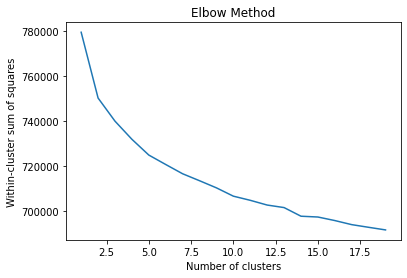

In [35]:
# use elbow method to find the best number of clusters
ls = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(x)
    ls.append(kmeans.inertia_)
plt.plot(range(1, 20), ls)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster sum of squares')
plt.show()

In [36]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel, LdaMulticore
from gensim.utils import simple_preprocess
from gensim.models.coherencemodel import CoherenceModel
from gensim.utils import ClippedCorpus
import matplotlib.pyplot as plt

In [101]:
# tokenize the text data
tokenized_text = [simple_preprocess(doc) for doc in docs]

print(tokenized_text[:3])

[['pesquisando', 'bastante', 'novo', 'comprar', 'resolver', 'aguardar', 'semana', 'cliente', 'porque', 'ocorrer', 'vários', 'desconto', 'promoção', 'em', 'esse', 'semana', 'ser', 'assim', 'recebi', 'desconto', 'cashback', 'cupom', 'varia', 'plataforma', 'assim', 'decidir', 'efetuar', 'compra', 'entender', 'melhor', 'custo', 'beneficio', 'ser', 'assim', 'setembro', 'recebi', 'oferta', 'produto', 'entendi', 'preço', 'além', 'cachback', 'efetuei', 'comprar', 'aguardei', 'semana', 'consumidor', 'efetuar', 'todo', 'expectativa', 'estavar', 'ancioso', 'estar', 'dentro', 'prazo', 'entregar', 'hoje', 'resolver', 'enviar', 'mensagem', 'perguntar', 'pedir', 'enviar', 'após', 'confirmação', 'comprar', 'pagamento', 'passado', 'dia', 'nenhum', 'retorno', 'complei', 'inclusive', 'site', 'confio', 'tambem', 'assinante', 'surpresa', 'após', 'pedir', 'informação', 'pedir', 'retorno', 'email', 'estar', 'ser', 'cancelar', 'ser', 'nenhum', 'justificativa', 'após', 'dia', 'realização', 'aguardei', 'chegar'

In [105]:
# tokenize the text data
tokenized_text = [simple_preprocess(doc) for doc in docs]

# create a corpus from a list of texts
dictionary = Dictionary(tokenized_text)
corpus = [dictionary.doc2bow(text) for text in tokenized_text]

# create a gensim LdaModel
lda = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=15)
coherence_model = CoherenceModel(model=lda,
                                 texts=tokenized_text, 
                                 corpus=corpus,
                                 dictionary=dictionary, 
                                 coherence='c_v')
coherence_model.get_coherence()

0.36861880932105906

In [142]:
def get_topics_words():
  x=lda.show_topics(num_words=10,formatted=False)
  topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]
  topics = []
  words = []
  #Below Code Prints Topics and Words
  for t, w in topics_words:
    topics.append(t)
    words.append(w)
  df_topics = pd.DataFrame({'topic': topics, 'words': words})
  return df_topics


,topic,words
0,8,"[pedir, contato, chegar, hering, informar, com..."
1,12,"[entregar, contato, compra, receber, informar,..."
2,7,"[compra, valor, comprar, pedir, site, produto,..."
3,0,"[compra, pedir, entregar, contato, produto, em..."
4,4,"[pedir, fazer, produto, contato, compra, site,..."


In [127]:
print(f"{lda.print_topics()[0][0]}    {lda.print_topics()[0][1]}")

0    0.029*"compra" + 0.020*"pedir" + 0.018*"entregar" + 0.014*"contato" + 0.012*"produto" + 0.011*"empresa" + 0.011*"entrar" + 0.008*"dizer" + 0.008*"chegar" + 0.008*"pois"


In [89]:
print(topics)

[['human', 'computer', 'system', 'interface'], ['graph', 'minors', 'trees', 'eps']]


In [90]:
for topic_id, topic in enumerate(topics):
  topic_words = [dictionary[word_id] for word_id, prob in lda.get_topic_terms(topic_id, topn=5)]
topic_words

['compra', 'receber', 'entregar', 'pedir', 'mercadoria']